In [28]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

In [68]:
from pydub import AudioSegment
import os

def convert_audio_to_pcm(source_folder, target_folder):
    """
    Convert all WAV files in the source folder to PCM format and replicate the folder structure in the target folder.
    """
    for subdir, dirs, files in os.walk(source_folder):
        for file in files:
            if file.endswith(".wav"):
                # Construct the full path for source and target
                source_path = os.path.join(subdir, file)
                relative_path = os.path.relpath(subdir, source_folder)  # Get the relative path to the source_folder
                target_dir = os.path.join(target_folder, relative_path)
                
                if not os.path.exists(target_dir):
                    os.makedirs(target_dir)
                
                target_path = os.path.join(target_dir, file)
                
                try:
                    # Load the source audio
                    audio = AudioSegment.from_wav(source_path)
                    
                    # Export the audio in WAV format with PCM codec
                    audio.export(target_path, format="wav", codec="pcm_s16le")
                    
                    print(f"Converted and saved: {target_path}")
                except Exception as e:
                    print(f"Error converting {source_path}: {e}")

In [69]:
# Specify your source and target directories
source_folder = "./RAVDESS_Output//"
target_folder = "./dataset"

convert_audio_to_pcm(source_folder, target_folder)

Converted and saved: ./dataset\Anger\03-01-05-01-01-01-01.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-02.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-03.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-04.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-05.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-06.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-07.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-08.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-09.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-10.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-11.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-12.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-13.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-14.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-15.wav
Converted and saved: ./dataset\Anger\03-01-05-01-01-01-16.wav
Converte

In [29]:
# Base directory of your dataset
data_dir = pathlib.Path("./RAVDESS_Output/")

In [30]:
# Fetch all the file paths which are in .wav format
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
filenames = tf.random.shuffle(filenames)

In [31]:
len(filenames)

1440

In [32]:
# Extract labels from the path
# Decode each path from bytes to string before splitting
labels = [path.decode("utf-8").split(os.path.sep)[-2] for path in filenames.numpy()]

In [33]:
# Define a function to encode labels
class_names = np.array(sorted(set(labels)))
label_to_index = dict((name, index) for index, name in enumerate(class_names))
labels = np.array([label_to_index[label] for label in labels])

In [34]:
# Split the dataset into training and validation
train_filenames, val_filenames = filenames[:int(len(filenames) * 0.8)], filenames[int(len(filenames) * 0.8):]
train_labels, val_labels = labels[:int(len(labels) * 0.8)], labels[int(len(labels) * 0.8):]

In [35]:
# A function to preprocess files into spectrograms which can be used as input to the model
def preprocess_file(file_path, label):
    # Load the raw data from the file as a waveform
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    audio = tf.squeeze(audio, axis=-1)
    # Convert the waveform to a spectrogram
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    spectrogram = tf.image.resize(spectrogram, [128, 128])
    spectrogram = tf.ensure_shape(spectrogram, (128, 128, 1))
    return spectrogram, label

In [36]:
# Preparing training and validation datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels)).map(preprocess_file, num_parallel_calls=AUTOTUNE)

In [37]:
val_files_ds = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
val_ds = val_files_ds.map(preprocess_file, num_parallel_calls=AUTOTUNE)

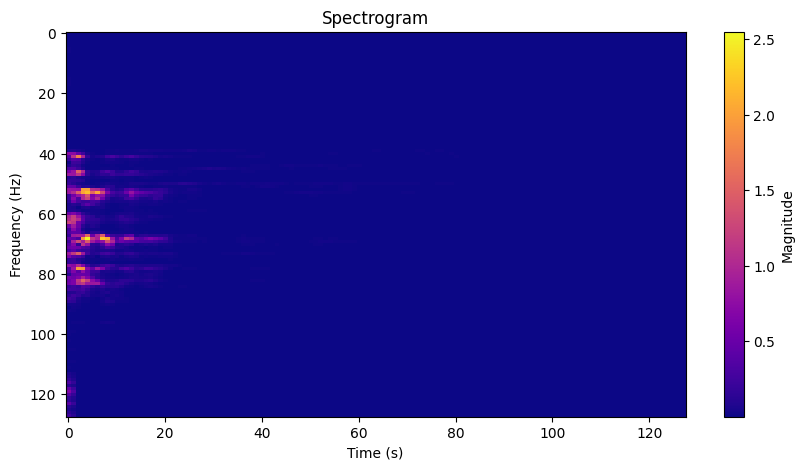

In [38]:
def plot_spectrogram(spectrogram):
    """
    Plot the spectrogram using Matplotlib.

    Args:
    - spectrogram: Spectrogram of the audio signal.
    - sample_rate: Sampling rate of the audio file.
    """
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

    # Plot the spectrogram if it has non-zero dimensions
    if spectrogram.shape[1] > 0:
        plt.figure(figsize=(10, 5))  # Adjust figure size as needed
        plt.imshow(spectrogram, aspect='auto', cmap='plasma')  # Plot the magnitude of the spectrogram
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Spectrogram')
        plt.colorbar(label='Magnitude')
        plt.show()
    else:
        print("Spectrogram has invalid shape for plotting.")

# Path to the audio file
file_path = './dataset/Anger/03-01-05-01-01-01-01.wav'

# Load the audio file and compute its spectrogram
spectrogram, label = preprocess_file(train_filenames[0], train_labels[0])

# Plot the spectrogram
plot_spectrogram(spectrogram)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization

model = Sequential([
    Input(shape=(128, 128, 1)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),  # Add an additional dense layer
    Dense(len(class_names), activation='softmax')
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds.batch(32), validation_data=val_ds.batch(32), epochs=20)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
<stack traces unavailable>
Data too short when trying to read string
	 [[{{node DecodeWav}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_10034]

In [ ]:
# Extracting training and validation accuracies
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting the accuracies
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [54]:
history.history

{'accuracy': [0.24430641531944275,
  0.2753623127937317,
  0.3706004023551941,
  0.38923394680023193,
  0.43271222710609436,
  0.48033127188682556,
  0.5051760077476501,
  0.544513463973999,
  0.5465838313102722,
  0.5693581700325012,
  0.6045548915863037,
  0.6563146710395813,
  0.7122153043746948,
  0.7329192757606506,
  0.7743270993232727,
  0.7784678936004639,
  0.7971014380455017,
  0.8095238208770752,
  0.8488612771034241,
  0.9089027047157288],
 'loss': [1.6354212760925293,
  1.5920530557632446,
  1.476686716079712,
  1.3647416830062866,
  1.2343894243240356,
  1.213322401046753,
  1.1049466133117676,
  1.105832815170288,
  1.0588874816894531,
  0.9938743710517883,
  0.9372265338897705,
  0.8011361360549927,
  0.7334371209144592,
  0.6562928557395935,
  0.5834592580795288,
  0.5601319670677185,
  0.5039141178131104,
  0.44119787216186523,
  0.4007973372936249,
  0.2806730270385742],
 'val_accuracy': [0.1735537201166153,
  0.3471074402332306,
  0.35537189245224,
  0.4710743725299